# Практическая работа 2. Парсинг HTML и консолидация данных

**Студент:** *Мареев Георгий Александрович*

**Вариант:** №13

**Бизнес-кейс:** анализ рынка видеоигр.

**Источник:** раздел "Лидеры продаж" в [Steam](URL "https://store.steampowered.com/")

**Задача:** собрать данные о названии игры, цене, скидке и дате выхода. Рассчитать средний размер скидки.

## Цель работы

Освоить продвинутые техники сбора данных путем парсинга HTML-страниц с сайта `https://store.steampowered.com/`, их последующей консолидации и проведения аналитического исследования для определения структуры спроса на различные видеоигры, их названия, цену, скидку и дату выходы.

## Теоретическая часть

**Парсинг HTML** — это процесс автоматизированного извлечения данных из веб-страниц. Веб-страницы написаны на языке гипертекстовой разметки (HTML), который имеет древовидную структуру. Парсеры анализируют эту структуру для навигации по ней и извлечения нужной информации (текста, ссылок, атрибутов).

**Ключевые библиотеки:**
- **`requests`**: позволяет отправлять HTTP-запросы к веб-серверу и получать в ответ HTML-код страницы. Это первый шаг любого парсинга — получение исходного кода.
- **`BeautifulSoup`**: создает из полученного HTML-кода объектное представление (дерево объектов), по которому можно легко перемещаться и искать нужные элементы с помощью тегов, классов, идентификаторов и других атрибутов. Это основной инструмент для извлечения данных из HTML.

### Шаг 1. Установка необходимых библиотек

In [1]:
!pip install -q requests beautifulsoup4 pandas matplotlib seaborn

### Шаг 2. Обновление парсера для сбора данных об играх

#### 1 Версия

Возьмем первые 5 страниц для анализа, на 1 странице 25 игр

In [2]:
from bs4 import BeautifulSoup
import re
import requests
import time
import pandas as pd

BASE_URL = 'https://store.steampowered.com/search/?filter=topsellers&cc=US&l=english&page={n};'
HEADERS = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}
PAGES_TO_PARSE = 5

data = []

* Создадим вспомогательные функции:
    + `clean_price()`: преобразование строки с ценой в float, для Free to Play, demo и пр. возращает None
    + `parse_result()`: извлечение информации об одной игре

* Применим их в цикле к каждой игре на странице `for page in range(1, PAGES_TO_PARSE + 1):`
* Соберем все в датафрейм, удалим дубликаты и подсчитаем средняя скидка по тем играм, у кого она есть

In [3]:
def clean_price(text: str) -> float | None:

    if not text:
        return None
    t = text.strip()
    # часто встречающиеся кейсы
    if re.search(r'\bfree\b', t, re.I):
        return 0.0
    if re.search(r'\bdemo\b', t, re.I):
        return None
    # убираем всё, кроме цифр, точки и запятой
    t = re.sub(r'[^\d,.\s]', '', t)
    t = t.replace(' ', '')
    if ',' in t and '.' in t:
        t = t.replace(',', '')
    else:
        t = t.replace(',', '.')
    try:
        return float(t) if t else None
    except ValueError:
        return None

def parse_result_row(row):
    title = row.select_one('.search_name .title')
    title = title.get_text(strip=True) if title else None

    release = row.select_one('.search_released')
    release = release.get_text(strip=True) if release else None

    disc_span = row.select_one('.search_discount span')
    # скидка приходит как "-50%"; переведём в число 50
    discount = None
    if disc_span:
        m = re.search(r'(-?\d+)\s*%', disc_span.get_text())
        if m:
            discount = abs(int(m.group(1)))

    price_box = row.select_one('.search_price')
    # у скидочных игр внутри может быть "стар. цена  новая цена"
    price_text = price_box.get_text(" ", strip=True) if price_box else ""
    # возьмём последнюю "часть" как актуальную цену
    parts = [p for p in price_text.split() if p.strip()]
    current_price = clean_price(parts[-1]) if parts else None

    # Если скидка есть, попробуем выделить "старую" цену (первая числовая)
    original_price = None
    if discount and len(parts) >= 2:
        # в некоторых случаях первая часть — старая цена
        original_price = clean_price(parts[0])

    return {
        "title": title,
        "release_date": release,
        "discount_pct": discount,
        "price_current": current_price,
        "price_original": original_price
    }


for page in range(1, PAGES_TO_PARSE + 1):
    url = f"{BASE_URL}search/?filter=topsellers&cc=US&l=english&page={page}"
    resp = requests.get(url, headers=HEADERS, timeout=30)
    if resp.status_code != 200:
        print(f"[warn] {url} -> {resp.status_code}")
        time.sleep(1)
        continue

    soup = BeautifulSoup(resp.text, "html.parser")
    rows = soup.select('a.search_result_row')
    if not rows:
        print(f"[info] На странице {page} результатов не нашли (возможно, разметка изменилась).")
        break

    for r in rows:
        data.append(parse_result_row(r))

    print(f"Страница {page}: собрано {len(rows)} записей (итого: {len(data)})")
    time.sleep(1.0)

#В DataFrame
df = pd.DataFrame(data)

df = df.dropna(subset=["title"]).drop_duplicates(subset=["title"]).reset_index(drop=True)

avg_discount = df["discount_pct"].dropna()
avg_discount_value = avg_discount.mean() if not avg_discount.empty else 0.0

print(f"\nВсего игр: {len(df)}")
print(f"Средний размер скидки (по тем, у кого она есть): {avg_discount_value:.2f}%")

display(df.head(10))


Страница 1: собрано 25 записей (итого: 25)
Страница 2: собрано 25 записей (итого: 50)
Страница 3: собрано 25 записей (итого: 75)
Страница 4: собрано 25 записей (итого: 100)
Страница 5: собрано 25 записей (итого: 125)

Всего игр: 125
Средний размер скидки (по тем, у кого она есть): 0.00%


,title,release_date,discount_pct,price_current,price_original
0,Battlefield™ 6,"Oct 10, 2025",None,None,None
1,Counter-Strike 2,"Aug 21, 2012",None,None,None
2,Steam Deck,"Jan 17, 2025",None,None,None
3,Little Nightmares III,"Oct 9, 2025",None,None,None
4,Blue Protocol: Star Resonance,"Oct 9, 2025",None,None,None
5,Digimon Story Time Stranger,"Oct 2, 2025",None,None,None
6,Megabonk,"Sep 18, 2025",None,None,None
7,Wuthering Waves,"Apr 28, 2025",None,None,None
8,Dead by Daylight,"Jun 14, 2016",None,None,None
9,Absolum,"Oct 9, 2025",None,None,None


Надо правильно получить размер скидки, цену со скидкой, цену без скидки

#### 2 Версия

- Доработаем параметры `filter`, `cc`, `l` — вынесем в конфигурацию (`PARAMS_BASE`) для гибкости и лёгкого изменения региона, языка и фильтра.
- Для обработки цен, которые представлены в виде неразрывных пробелов, будем использовать `NBSP = "\u00a0"`, чтобы корректно заменять их на обычные пробелы перед парсингом.
- Используем `data-price-final` (в центах) и `data-discount` из HTML-атрибутов для более точного и надёжного извлечения цены и скидки.
- Добавим fallback-логику: если структурированные атрибуты отсутствуют — парсим текст (например, `.discount_final_price`, `.discount_pct`).
- Улучшим очистку цен: распознаём `Free`, `Demo`, `Subscription`, корректно обрабатываем запятые, точки и валютные символы.
- Выводим две метрики средней скидки: только по играм со скидкой и по всем играм (без скидки = 0%).

In [4]:
import re
import time
import requests
import pandas as pd
from bs4 import BeautifulSoup


BASE_URL = "https://store.steampowered.com/search/"
HEADERS = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                  "AppleWebKit/537.36 (KHTML, like Gecko) "
                  "Chrome/123.0.0.0 Safari/537.36"
}
PAGES_TO_PARSE = 5
REQUEST_DELAY_SEC = 1.0
PARAMS_BASE = {
    "filter": "topsellers",
    "cc": "US",
    "l": "english",
}


NBSP = "\u00a0"

In [5]:
def _to_float_price(s: str) -> float | None:
    if not s:
        return None
    t = s.strip().replace(NBSP, " ")
    if re.search(r"\bfree\b", t, re.I):
        return 0.0
    if re.search(r"\b(subscription|demo)\b", t, re.I):
        return None
    t = re.sub(r"[^\d,.\s]", "", t).replace(" ", "")
    if "," in t and "." in t:
        t = t.replace(",", "")
    else:
        t = t.replace(",", ".")
    try:
        return float(t) if t else None
    except ValueError:
        return None

def parse_result_row(row) -> dict:
    title_el = row.select_one(".search_name .title")
    title = title_el.get_text(strip=True) if title_el else None

    release_el = row.select_one(".search_released")
    release_date = release_el.get_text(strip=True) if release_el else None

    # контейнеры Steam с атрибутами
    price_wrap = row.select_one(".search_price_discount_combined")
    disc_block = row.select_one(".discount_block")

    # 1) процент скидки из атрибута
    discount_pct = None
    if disc_block and disc_block.has_attr("data-discount"):
        try:
            discount_pct = int(disc_block["data-discount"])
        except Exception:
            discount_pct = None
    if discount_pct is None:
        # запасной вариант из текста, если атрибута нет
        disc_el = row.select_one(".discount_pct")
        if disc_el:
            m = re.search(r"-?(\d+)\s*%", disc_el.get_text())
            if m:
                discount_pct = int(m.group(1))

    # 2) текущая цена из data-price-final (в центах)
    price_current = None
    if price_wrap and price_wrap.has_attr("data-price-final"):
        try:
            cents = int(price_wrap["data-price-final"])
            price_current = round(cents / 100.0, 2)
        except Exception:
            price_current = None

    # 3) дополнительно читаем видимые цены (особенно для original/final)
    orig_el = row.select_one(".discount_original_price")
    final_el = row.select_one(".discount_final_price")

    price_original = _to_float_price(orig_el.get_text()) if orig_el else None

    # final из текста — если нет data-price-final или это Free
    final_text_val = _to_float_price(final_el.get_text()) if final_el else None

    # Приоритет: если текстовый final дал 0.0 (Free) — считаем его истинным
    if final_text_val is not None:
        price_current = final_text_val


    if price_current is None:
        price_box = row.select_one(".search_price")
        if price_box:
            chunks = list(price_box.stripped_strings)
            if chunks:
                price_current = _to_float_price(chunks[-1])

    return {
        "title": title,
        "release_date": release_date,
        "discount_pct": discount_pct,
        "price_original": price_original,
        "price_current": price_current,
    }


Собираем все данные в датафрейм, удаляем пустые названия и дубликаты, расччитываем среднюю скидку и  выводим первые 10 строк

In [6]:
all_rows = []
for page in range(1, PAGES_TO_PARSE + 1):
    params = {**PARAMS_BASE, "page": page}
    r = requests.get(BASE_URL, params=params, headers=HEADERS, timeout=30)
    if r.status_code != 200:
        print(f"[warn] page {page}: HTTP {r.status_code}")
        time.sleep(REQUEST_DELAY_SEC)
        continue

    soup = BeautifulSoup(r.text, "html.parser")
    rows = soup.select("a.search_result_row")
    if not rows:
        print(f"[info] page {page}: нет результатов (верстка изменилась?)")
        break

    for row in rows:
        all_rows.append(parse_result_row(row))

    print(f"Стр. {page}: собрано {len(rows)} (итого {len(all_rows)})")
    time.sleep(REQUEST_DELAY_SEC)

# DataFrame
df = pd.DataFrame(all_rows)
df = (df.dropna(subset=["title"])
        .drop_duplicates(subset=["title"])
        .reset_index(drop=True))


avg_disc_all = df["discount_pct"].dropna()
avg_discount = avg_disc_all.mean() if not avg_disc_all.empty else 0.0

avg_discount_including_no_sale = df["discount_pct"].fillna(0).mean()

print(f"\nВсего уникальных игр: {len(df)}")
print(f"Средняя скидка среди игр со скидкой: {avg_discount:.2f}%")
print(f"Средняя скидка по всем позициям (без скидки считаем 0%): {avg_discount_including_no_sale:.2f}%")

display(df.head(10))

Стр. 1: собрано 25 (итого 25)
Стр. 2: собрано 25 (итого 50)
Стр. 3: собрано 25 (итого 75)
Стр. 4: собрано 25 (итого 100)
Стр. 5: собрано 25 (итого 125)

Всего уникальных игр: 125
Средняя скидка среди игр со скидкой: 12.03%
Средняя скидка по всем позициям (без скидки считаем 0%): 8.57%


,title,release_date,discount_pct,price_original,price_current
0,Battlefield™ 6,"Oct 10, 2025",0.0,NaN,69.99
1,Counter-Strike 2,"Aug 21, 2012",NaN,NaN,0.00
2,Steam Deck,"Jan 17, 2025",0.0,NaN,399.00
3,Little Nightmares III,"Oct 9, 2025",0.0,NaN,39.97
4,Blue Protocol: Star Resonance,"Oct 9, 2025",NaN,NaN,0.00
5,Digimon Story Time Stranger,"Oct 2, 2025",0.0,NaN,69.99
6,Megabonk,"Sep 18, 2025",0.0,NaN,9.99
7,Wuthering Waves,"Apr 28, 2025",NaN,NaN,0.00
8,Dead by Daylight,"Jun 14, 2016",0.0,NaN,19.99
9,Absolum,"Oct 9, 2025",10.0,24.99,22.49


### Шаг 3. Очистка и преобразование данных о ценах

Собранные данные о размере скидки, цене без скидки, текущая цена представлены в разном формате, так как есть бесплатные игры (Free), но поля `discount_pct`,`price_original` для них NaN (например Counter-Strike 2), и игры, которые вышли недавно/ без скидки: `discount_pct` - 0.0, `price_original` - NaN. Нам нужно преобразовать их в числовой формат для анализа.
* Бесплатные игры (Free):
    + для них `discount_pct`: 0.0
    + `price_original` : 0.0 (т.к. нет изначальной цены, но числовой формат нужен).
* Игры без скидки
    + если `discount_pct` == 0.0 и `price_original` отсутствует, то следует поставить `price_original` = `price_current.`

In [7]:
df_fixed = df.copy()

mask_free = df_fixed["price_current"] == 0.0
df_fixed.loc[mask_free, "discount_pct"] = 0.0
df_fixed.loc[mask_free, "price_original"] = 0.0


mask_no_disc = (df_fixed["discount_pct"] == 0.0) & (df_fixed["price_original"].isna())
df_fixed.loc[mask_no_disc, "price_original"] = df_fixed.loc[mask_no_disc, "price_current"]


display(df_fixed.head(10))

,title,release_date,discount_pct,price_original,price_current
0,Battlefield™ 6,"Oct 10, 2025",0.0,69.99,69.99
1,Counter-Strike 2,"Aug 21, 2012",0.0,0.00,0.00
2,Steam Deck,"Jan 17, 2025",0.0,399.00,399.00
3,Little Nightmares III,"Oct 9, 2025",0.0,39.97,39.97
4,Blue Protocol: Star Resonance,"Oct 9, 2025",0.0,0.00,0.00
5,Digimon Story Time Stranger,"Oct 2, 2025",0.0,69.99,69.99
6,Megabonk,"Sep 18, 2025",0.0,9.99,9.99
7,Wuthering Waves,"Apr 28, 2025",0.0,0.00,0.00
8,Dead by Daylight,"Jun 14, 2016",0.0,19.99,19.99
9,Absolum,"Oct 9, 2025",10.0,24.99,22.49


### Шаг 4: Анализ и визуализация данных

Теперь, когда у нас есть числовые данные о ценах, мы можем проанализировать их распределение и ключевые показатели.

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

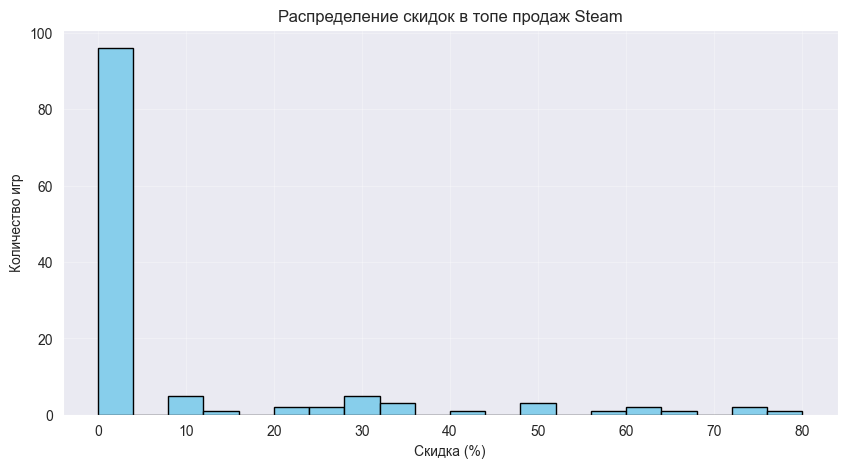

In [9]:
plt.figure(figsize=(10,5))
df_fixed["discount_pct"].hist(bins=20, color="skyblue", edgecolor="black")
plt.xlabel("Скидка (%)")
plt.ylabel("Количество игр")
plt.title("Распределение скидок в топе продаж Steam")
plt.grid(alpha=0.3)
plt.show()


В "топе" много бесплатных игр из-за чего на графике виден перевес.

Отберем для анализа только платные игры со скидкой

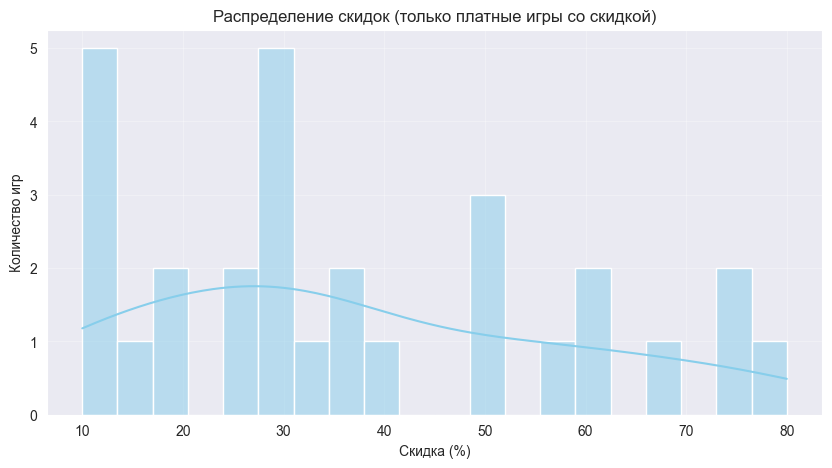

In [10]:
df_paid_discounted = df_fixed[(df_fixed["price_current"] > 0) & (df_fixed["discount_pct"] > 0)]

plt.figure(figsize=(10,5))
sns.histplot(
    data=df_paid_discounted,
    x="discount_pct",
    bins=20,
    kde=True,
    color="skyblue"
)
plt.xlabel("Скидка (%)")
plt.ylabel("Количество игр")
plt.title("Распределение скидок (только платные игры со скидкой)")
plt.grid(alpha=0.3)
plt.show()


Рассчитаем средний размер скидки

In [11]:
mean_discount_paid_with_sale = df_fixed.loc[(df_fixed["price_current"] > 0) & (df_fixed["discount_pct"] > 0), "discount_pct"].mean()

print(f"Средний размер скидки среди платных игр со скидкой: {mean_discount_paid_with_sale:.2f}%")


Средний размер скидки среди платных игр со скидкой: 36.93%


#### Построим график распределения цен игр со скидкой и без

Этот график как раз показывает распределение цен:

* для игр без скидки (текущие цены),

* для игр со скидкой (их оригинальные цены, до применения скидки).

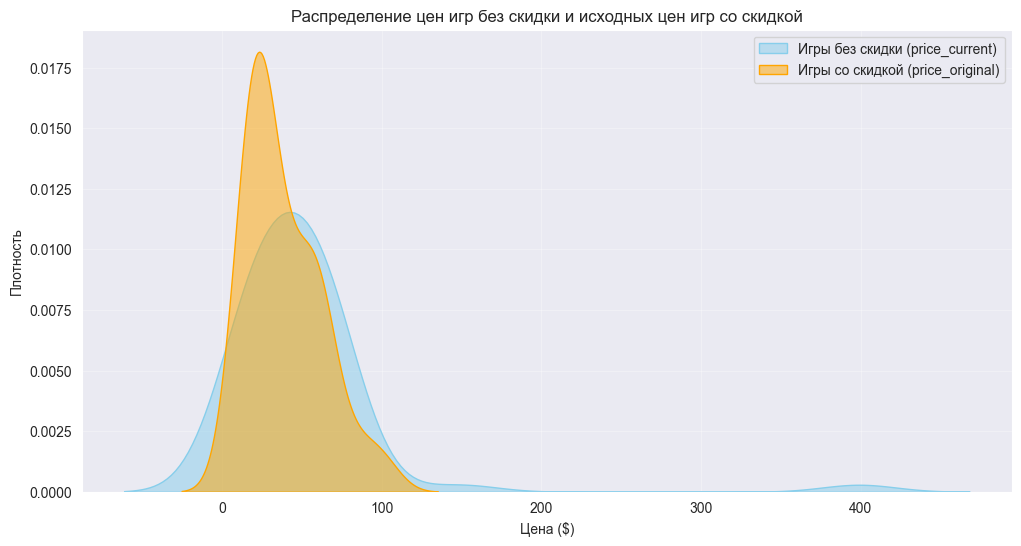

In [12]:
no_discount = df_fixed[(df_fixed["price_current"] > 0) & (df_fixed["discount_pct"] == 0)]
with_discount = df_fixed[(df_fixed["price_current"] > 0) & (df_fixed["discount_pct"] > 0)]

plt.figure(figsize=(12,6))
sns.kdeplot(no_discount["price_current"], label="Игры без скидки (price_current)", fill=True, color="skyblue", alpha=0.5)
sns.kdeplot(with_discount["price_original"], label="Игры со скидкой (price_original)", fill=True, color="orange", alpha=0.5)

plt.xlabel("Цена ($)")
plt.ylabel("Плотность")
plt.title("Распределение цен игр без скидки и исходных цен игр со скидкой")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Добавим третий слой — фактические цены игр со скидкой (после применения скидки).
Так получится сразу сравнить:

* price_current без скидки (обычные цены),

* price_original со скидкой (исходные цены до распродажи),

* price_current со скидкой (цены после скидки).

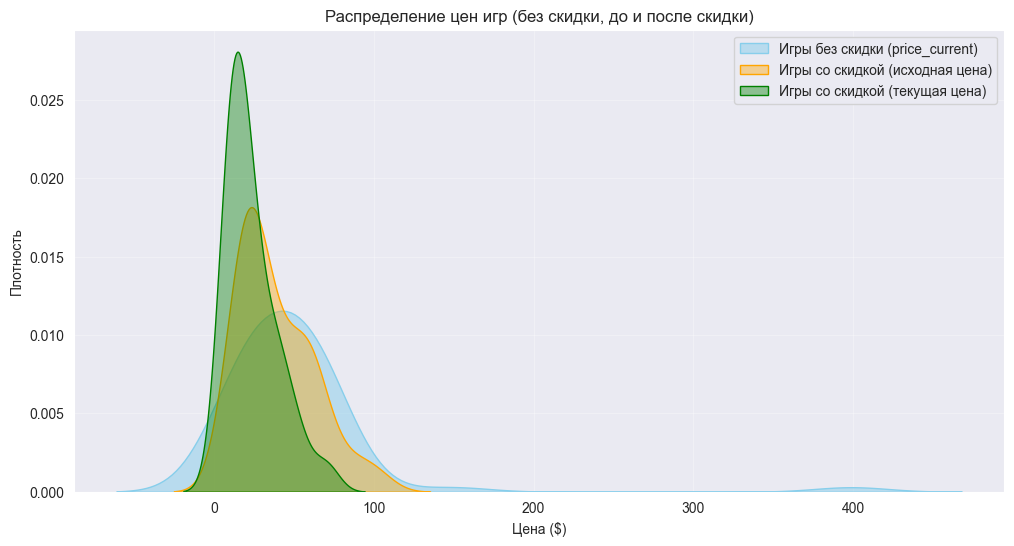

In [13]:
no_discount = df_fixed[(df_fixed["price_current"] > 0) & (df_fixed["discount_pct"] == 0)]
with_discount = df_fixed[(df_fixed["price_current"] > 0) & (df_fixed["discount_pct"] > 0)]

plt.figure(figsize=(12,6))

sns.kdeplot(no_discount["price_current"], fill=True, color="skyblue", alpha=0.5, label="Игры без скидки (price_current)")
sns.kdeplot(with_discount["price_original"], fill=True, color="orange", alpha=0.4, label="Игры со скидкой (исходная цена)")
sns.kdeplot(with_discount["price_current"], fill=True, color="green", alpha=0.4, label="Игры со скидкой (текущая цена)")

plt.xlabel("Цена ($)")
plt.ylabel("Плотность")
plt.title("Распределение цен игр (без скидки, до и после скидки)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


### Шаг 5: Выводы по анализу

На основе анализа данных о ценах и скидках в разделе **"Лидеры продаж" Steam** можно сделать следующие бизнес-выводы:

1. **Структура цен**:
   - Большинство игр без скидок имеют цену в диапазоне `$20–70`, что характерно для новых релизов и крупных проектов (AAA).
   - Игры со скидкой изначально стоят дороже (часто `от $40 до $100`), но именно они чаще всего участвуют в распродажах.

2. **Роль скидок**:
   - Средний размер скидки среди платных игр со скидкой составляет около `40%`, что согласуется с визуальными распределениями.
   - Наиболее частые скидки находятся в диапазоне `20–50%`, именно они являются "рабочим инструментом" для стимулирования продаж.
   - Крайние скидки (`70–80%`) встречаются редко, но именно они позволяют старым играм вновь попадать в топ продаж.

3. **Влияние на цены**:
   - Сравнение *исходных* и *текущих* цен игр со скидкой показывает значительное смещение вниз:
     многие проекты после скидки попадают в диапазон `$10–30`, где сосредоточен основной спрос игроков.
   - Бесплатные игры (`Free to Play`) составляют заметную долю топа и демонстрируют важность модели монетизации через внутриигровые покупки.

4. **Бизнес-стратегия**:
   - Топ продаж формируется за счёт сочетания **новых релизов без скидок по высокой цене** и **старых проектов со значительными скидками**.
   - Для издателей оптимальная стратегия — предлагать скидки в диапазоне `30–50%`, которые воспринимаются игроками как привлекательные и обеспечивают максимальный рост продаж.
